<a href="https://colab.research.google.com/github/NadiaFinzi/diplodatos-mumuki-equipo1/blob/main/Mumuki_E4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2021**

---
## Mentoría MUMUKI
## **"Predicción de deserción en una plataforma educativa para aprender a programar".**

### Mentor

- Bulgarelli, Franco Leonardo

### Integrantes

- Finzi, Nadia
- Gherra C., Estefanía Inés
- Primo, Eugenia


# Bibliotecas, funciones e importación de datos

In [ ]:
# Librerías y configuraciones generales

# Esenciales
import pandas as pd
import numpy as np
from datetime import datetime, date, time, timedelta
import calendar

# Visualizacion
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams['grid.color'] = 'grey'
plt.rcParams['grid.alpha'] = 0.2 
plt.rcParams['grid.linestyle'] = "-."

%matplotlib inline
import seaborn as sns

# Varios
import warnings
warnings.filterwarnings('ignore')

# Entrenamiento
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

# Métricas
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import f1_score

In [ ]:
# Definición de funciones y procedimientos propios

def graficar_boxplot(dataframe, columna, aclaracion_titulo, label_x, pie_grafico):
  fig = plt.figure(figsize=(8, 6))
  g = sns.boxenplot(data=dataframe, x= columna, color='salmon')
  plt.title('Boxplot de la variable ' + columna + aclaracion_titulo, fontsize=14, weight='bold')
  plt.ylabel("")
  plt.xlabel("\n" + label_x, fontsize=10)
  plt.annotate( pie_grafico, xy=(0.3, -0.25), xycoords='axes fraction', ha='right', va='center', fontsize=12)

def submissions_correctas(df):
  return df[(df["submission_status"] == "passed") | (df["submission_status"] == "passed_with_warnings")]

def submissions_incorrectas(df):
  return df[(df["submission_status"] == "failed") | (df["submission_status"] == "errored")]

def ordenar_y_agrupar(df):
  return df.sort_values(["student_uid", "submission_created_at"]).reset_index(drop=True).groupby(["student_uid", "exercise_new_id"])

def plot_scatter_grid(x, y, exercises):
  row = 3
  col = 2
  i = 1 # inicia el conteo

  plt.figure(figsize = (20,15))
  for exercise in exercises:
    selector = estudiante_por_ejercicio[estudiante_por_ejercicio["exercise_new_id"] == exercise]
    plt.subplot(row, col, i)
    plt.title("Ejercicio " + str(exercise))
    sns.scatterplot(x = x, y = y, hue = 'cond_cant_ejer_resueltos', data = selector, facecolor="dodgerblue", edgecolor="k", palette=["blue", "red"])
    i += 1

  plt.subplots_adjust(wspace = 0.3, hspace = 0.5) 
  plt.show()

# Funciones para armar modelos de regresión logística

def data_por_student(ids_ejercicios, imputar_con_constante, imputacion_nan):
  # Base con desagregación de ejercicios, por variables: intentos_incorrectos y tiempo_total.
  data = estudiante_por_ejercicio[estudiante_por_ejercicio.exercise_new_id.isin(ids_ejercicios)][["student_uid", "cond_cant_ejer_resueltos", "exercise_new_id", "intentos_incorrectos", "tiempo_total", "ultimo_estado"]]
  
  data["ultimo_estado"] = 0  # 0 = resolvió el ejercicio, sin importar en qué estado
  
  # Armamos la tabla pivot
  data["exercise_new_id"] = data["exercise_new_id"].astype(str)
  data_por_estudiante = pd.pivot_table(data, index= ["student_uid", "cond_cant_ejer_resueltos"], columns = ["exercise_new_id"], fill_value= np.nan)
  data_por_estudiante.columns = ['_'.join(col).strip() for col in data_por_estudiante.columns.values]
  
  # Llenamos el último estado con 1 si no resolvió cada ejercicio
  for col in data_por_estudiante.columns[data_por_estudiante.columns.str.contains("ultimo_estado")]:
    data_por_estudiante[col] = data_por_estudiante[col].fillna(1) 
  
  # Imputamos los NaN's en intentos incorrectos y en tiempo invertido de cada ejercicio
  if imputar_con_constante:
    data_por_estudiante.fillna(imputacion_nan, inplace = True) # Asigna la imputacion_nan para variables tiempo e intentos incorrectos
  else:
    for col in data_por_estudiante.columns: 
      data_por_estudiante[col] = np.where(data_por_estudiante[col].isna(), data_por_estudiante[col].max(), data_por_estudiante[col])
  return data_por_estudiante.reset_index()

def regresion_logistica(df, test_size, drop_ultimo_estado):
  X = df.drop(columns = ["cond_cant_ejer_resueltos"])
  if drop_ultimo_estado:
    X.drop(columns = X.columns[X.columns.str.contains("ultimo_estado")], inplace = True)
  y = df.cond_cant_ejer_resueltos
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
  lr = LogisticRegression(random_state=0).fit(X_train, y_train)
  return X_train, X_test, y_train, y_test, lr.predict(X_train), lr.predict(X_test)

def construir_regresion_logistica(ids_ejercicios, test_size, imputar_con_constante, imputacion_nan, drop_ultimo_estado):
  return regresion_logistica(data_por_student(ids_ejercicios, imputar_con_constante, imputacion_nan), test_size, drop_ultimo_estado)

In [ ]:
# Apertura del dataset desde Google Drive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

def connect_to_drive():
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  return GoogleDrive(gauth)

def read_csv_from_drive(drive, id, filename):
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(filename)  
  return pd.read_csv(filename)

drive = connect_to_drive()  # utilización de la función de apertura de archivos desde drive
df_submissions_0 = read_csv_from_drive(drive, '1oqeKaq164fYieUs6WODv53tF4hl7QY9N', 'df_submissions_python.csv') # el 2° parámetro es el id del archivo (terminación del link en drive)

# 1oqeKaq164fYieUs6WODv53tF4hl7QY9N
# [Fuente: https://colab.research.google.com/drive/1bPwYa_uumNJ7N6NazqSwLr-8dmiCaIj8]


# GENERACIÓN DE DF 

## Limpieza y filtrado

In [ ]:
# Corrección de nombres

df_submissions_0["exercise_name"] = np.where(df_submissions_0["exercise_name"] == 'Más booleanos', 'El retorno del booleano' , df_submissions_0["exercise_name"])
df_submissions_0["exercise_name"] = np.where(df_submissions_0["exercise_name"] == 'PIenso que así es más fácil', 'Pienso que así es más fácil', df_submissions_0["exercise_name"])

# Eliminamos "Calefones": 
df_submissions_0 = df_submissions_0[df_submissions_0["exercise_name"] != "Calefones"]

_orden_ejer = {"No tan distintos": 1, "Funciones, declaración": 2, "Funciones, uso": 3, "Probando funciones": 4, "Haciendo cuentas": 5, "Poniendo topes": 6, "¿Es par?": 7, "Libros de la buena memoria": 8, "Booleanos": 9, "Palabras, sólo palabras": 10, "Operando strings": 11, "¡GRITAR!": 12, "¿Y qué tal si...?":13, "¿De qué signo sos?": 14, "El retorno del booleano": 15, "Los premios": 16, "Tipos de datos": 17, "Datos de todo tipo": 18, 
        "Comprando Hardware": 19, "¿Me conviene?": 20, "Triangulos": 21, "Cuadrados": 22, "¿Está afinado?": 23, "¿Está cerca?": 24, "Cartelitos": 25, "Más Cartelitos": 26, "Cartelitos óptimos": 27, "Cara o ceca": 28, "¡Envido!": 29, "¡Quiero retruco!": 30, "¡Quiero vale cuatro!": 31,
        "¿Y el tablero?": 32, "Impresión por pantalla": 33, "Martin Fierro": 34, "¿Y los procedimientos?": 35, "¿Y el program?": 36, "Conversiones": 37, "El círculo de la vida": 38, "Pienso que así es más fácil": 39, "Esto no tiene valor": 40, "Variables globales": 41, "Volviéndonos ricos": 42, "¿Y esto cuánto vale?": 43}

# Mapeo del nombre de los ejercicios con su correspondiente orden dentro de la guía:
df_submissions_0["exercise_new_id"] = df_submissions_0["exercise_name"].map(_orden_ejer)
df_submissions_0["exercise_new_id"] = df_submissions_0["exercise_new_id"].apply(int)

# Eliminamos la columna del viejo id ya que no sera utilizada de aqui en adelante
df_submissions_0 = df_submissions_0.drop("exercise_eid", axis = 1)

# Eliminamos las columnas que no tienen datos
df_submissions_0 = df_submissions_0.drop("feedback", axis = 1)

# Pasamos la fecha a un formato datetime
df_submissions_0["submission_created_at"] = pd.to_datetime(df_submissions_0['submission_created_at'])

# Reemplazamos las listas vacías en test_results por NaN's
df_submissions_0["test_results"] = df_submissions_0.test_results.replace("[]", np.nan)

# Corregimos un outlier (failed que no compilaba y debería ser errored) a partir de result
df_submissions_0["submission_status"] = np.where((df_submissions_0.submission_status == "failed") & (df_submissions_0.result.notna()) , "errored", df_submissions_0.submission_status)

# Se filtran (excluyen por el momento) las pruebas: 
df_submissions = df_submissions_0[df_submissions_0["sid"] != -1]

# Se filtran (excluyen por el momento) status pending y aborted:
df_submissions = df_submissions[~df_submissions["submission_status"].isin(["pending", "aborted"])]

# Se filtran a estudiantes que tuvieron un único envío o son inválidos (por definición o porque su período de trabajo es mayor a un cuatrimestre):
df_submissions = df_submissions[~df_submissions["student_uid"].isin([75, 142, 361, 97, -1])]

# Se filtran ejercicios que fueron modificados y resueltos, en definitiva, por muy pocos estudiantes
df_submissions = df_submissions[df_submissions["exercise_new_id"] != 7]

# Obtenemos el periodo al que pertenecen l@s estudiantes para poder identificar los cursos: 
    # Creamos una columna que sólo indique el año: 
df_submissions["año"] = df_submissions["submission_created_at"].dt.year

    # Creamos una columna que sólo indique el cuatrimestre: 
df_submissions["cuatrimestre"] = np.where(df_submissions["submission_created_at"].dt.month.isin([ 5,  6,  7, 8]), "2 cuatr.","3 cuatr.")

    # Creamos una columna que sólo indique el día:
dias = {0: "1-Lunes", 1: "2-Martes", 2: "3-Miércoles", 3: "4-Jueves", 4: "5-Viernes", 5: "6-Sábado", 6: "7-Domingo"}
df_submissions["dia"] = df_submissions["submission_created_at"].dt.dayofweek
df_submissions["dia"].replace(dias, inplace =True)


## Cálculo de tiempos

In [ ]:
# Tiempo (en segundos) entre cada envío por estudiante:

intervalos_tiempo_por_estudiante = df_submissions.sort_values(by=["student_uid", "submission_created_at"]).groupby('student_uid').submission_created_at.diff().dt.total_seconds().round().reset_index()
intervalos_tiempo_por_estudiante["student_uid"] =  df_submissions.sort_values("student_uid").student_uid.reset_index(drop=True)
intervalos_tiempo_por_estudiante = intervalos_tiempo_por_estudiante.rename(columns = {"submission_created_at": "tiempo_entre_envios"}).drop(columns = "index")
intervalos_tiempo_por_estudiante = intervalos_tiempo_por_estudiante[intervalos_tiempo_por_estudiante.tiempo_entre_envios.between(3, 1200)]

# Tiempo total
tiempo_recorrido_por_estudiante = intervalos_tiempo_por_estudiante.groupby("student_uid").tiempo_entre_envios.sum()

# Tiempo (en segundos) entre cada envío por estudiante y ejercicio:
tiempo_entre_envios_por_ejercicio = df_submissions.sort_values(by=["student_uid", "exercise_new_id", "submission_created_at"]).groupby(by=['student_uid', "exercise_new_id"]).submission_created_at.diff().dt.total_seconds().apply(np.ceil).reset_index()

# Agregamos la información del estudiante y del ejercicio en cuestión
tiempo_entre_envios_por_ejercicio = tiempo_entre_envios_por_ejercicio.fillna(0).rename(columns = {"submission_created_at": "tiempo_entre_intentos"}).drop(columns = ["index"])
tiempo_entre_envios_por_ejercicio[["student_uid", "exercise_new_id", "submission_created_at"]] = df_submissions.sort_values(by=["student_uid", "exercise_new_id", "submission_created_at"]).reset_index()[["student_uid", "exercise_new_id", "submission_created_at"]]

tiempo_entre_envios_por_ejercicio["tiempo_intento_modificado"] = tiempo_entre_envios_por_ejercicio.tiempo_entre_intentos.apply(lambda row: 0 if row > 1200 else row)

# Nuevo tiempo total (en segundos) para cada estudiante en cada ejercicio
tiempo_total_por_ejercicio_2 = tiempo_entre_envios_por_ejercicio.groupby(by=['student_uid', "exercise_new_id"]).agg({"tiempo_intento_modificado": "sum", "submission_created_at": "nunique"}).reset_index()
tiempo_total_por_ejercicio_2.rename(columns = {"tiempo_intento_modificado": "tiempo_total", "submission_created_at": "intentos_totales"}, inplace = True)
tiempo_total_por_ejercicio_2

,student_uid,exercise_new_id,tiempo_total,intentos_totales
0,76,2,0.0,1
1,76,3,0.0,2
2,76,6,0.0,1
3,76,9,915.0,5
4,76,10,20.0,2
...,...,...,...,...
7810,359,43,0.0,1
7811,362,21,87.0,3
7812,363,25,61.0,3
7813,363,26,151.0,4


## Construcción de nuevo df con métricas por estudiante

In [ ]:
# Por cada estudiante obtenemos la cantidad de ejercicios con status passed o passed_with_warnings que realizó:
#filtro_status = submissions_correctas(df_submissions)
filtro_status = df_submissions
group_ejer = filtro_status[["student_uid", "exercise_new_id"]]
group_ejer = group_ejer.groupby(["student_uid"]).nunique().rename(columns = {'exercise_new_id': 'ejercicios_resueltos'})

# Creamos la columna de desercion:
# Regla de decision: 
criterio_por_ejercicios_resueltos = group_ejer["ejercicios_resueltos"].quantile(0.25)
#criterio_por_ejercicios_resueltos = 30

df_cond_ejer = group_ejer.copy()
df_cond_ejer["cond_cant_ejer_resueltos"] = np.where(df_cond_ejer["ejercicios_resueltos"] < criterio_por_ejercicios_resueltos, 1, 0)

df_cond_ejer = df_cond_ejer.reset_index() 

# -------

filtro_fallidos = submissions_incorrectas(df_submissions)

# Envíos fallidos por estudiante, por guía/lección, y por ejercicio.

df_fallidos = filtro_fallidos.groupby(['student_uid','exercise_new_id'])['sid'].count().reset_index().rename(columns = {'sid': 'intentos_fallidos_max_ejer'}).sort_values(["student_uid", "intentos_fallidos_max_ejer"], ascending = [True, False])

# Regla de decisión: 
criterio_por_intentos_fallidos = df_fallidos.sort_values(["student_uid", "intentos_fallidos_max_ejer"], ascending = [True, False]).drop_duplicates("student_uid")["intentos_fallidos_max_ejer"].quantile(0.75)

# Creamos la columna de deserción:
df_cond_fallos_ejer = df_fallidos.copy()[["student_uid", "intentos_fallidos_max_ejer"]]
df_cond_fallos_ejer["cond_fallos_ejer"] = np.where(df_fallidos["intentos_fallidos_max_ejer"] > criterio_por_intentos_fallidos, 1, 0)

df_cond_fallos_ejer = df_cond_fallos_ejer.sort_values('intentos_fallidos_max_ejer', ascending = False).drop_duplicates('student_uid')

# -------

# Cantidad de ejercicios intentados (en cualquier estado) por persona

group_ejer_int = df_submissions[["student_uid", "exercise_new_id"]]
group_ejer_int = group_ejer_int.groupby(["student_uid"]).nunique().rename(columns = {'exercise_new_id': 'ejercicios_totales'})
group_ejer_int = group_ejer_int.reset_index()

# -------

intervalos_tiempo_por_estudiante = df_submissions.sort_values(by=["student_uid", "submission_created_at"]).groupby('student_uid').submission_created_at.diff().dt.total_seconds().round().reset_index()
intervalos_tiempo_por_estudiante["student_uid"] = df_submissions.sort_values("student_uid").student_uid.reset_index(drop=True)
intervalos_tiempo_por_estudiante = intervalos_tiempo_por_estudiante.rename(columns = {"submission_created_at": "tiempo_total_invertido"}).drop(columns = "index")

# Nos quedamos con los intervalos de tiempo que se hayan realizado entre 3 segundos y 20 minutos
intervalos_tiempo_por_estudiante = intervalos_tiempo_por_estudiante[intervalos_tiempo_por_estudiante.tiempo_total_invertido.between(3, 1200)]
df_cond_tiempo_ejer = intervalos_tiempo_por_estudiante.groupby('student_uid', as_index=False).sum()



# DF con las condiciones obtenidas a partir de las metricas de deserción

df_condiciones = df_cond_ejer.merge(df_cond_tiempo_ejer, on = "student_uid", how = "outer")
df_condiciones = df_condiciones.merge(df_cond_fallos_ejer, on = "student_uid", how = "outer")
df_condiciones = df_condiciones.merge(group_ejer_int, on = "student_uid", how = "outer")
df_condiciones = df_condiciones.fillna(0)
df_condiciones['ejercicios_fallidos'] = df_condiciones.ejercicios_totales - df_condiciones.ejercicios_resueltos

# -------
df_condiciones['tiempo_prom_por_ej_correcto'] = df_condiciones.tiempo_total_invertido / df_condiciones.ejercicios_resueltos
df_condiciones['tiempo_prom_por_ejercicio'] = df_condiciones.tiempo_total_invertido / df_condiciones.ejercicios_totales

# Regla de decisión: 
criterio_por_tiempo_por_ejercicio = df_condiciones["tiempo_prom_por_ejercicio"].quantile(0.75)

df_condiciones["cond_tiempo_prom_ejer"] = np.where(df_condiciones["tiempo_prom_por_ejercicio"] > criterio_por_tiempo_por_ejercicio, 1, 0)

# -------

intentos_totales = df_submissions.groupby('student_uid', as_index=False).sid.count().rename(columns={"sid":"intentos_totales"}) # envios totales por persona
intentos_incorrectos = submissions_incorrectas(df_submissions).groupby('student_uid', as_index=False).sid.count().rename(columns={"sid":"intentos_incorrectos"}) # envios fallidos por persona
intentos_correctos = submissions_correctas(df_submissions).groupby('student_uid', as_index=False).sid.count().rename(columns={"sid":"intentos_correctos"}) # envios correctos por persona

# Agregamos las columnas con cantidad de intentos totales y distinguidos por estado
df_condiciones = df_condiciones.merge(intentos_totales, on = "student_uid", how = "outer")
df_condiciones = df_condiciones.merge(intentos_incorrectos, on = "student_uid", how = "outer")
df_condiciones = df_condiciones.merge(intentos_correctos, on = "student_uid", how = "outer")

df_condiciones = df_condiciones[["student_uid", "ejercicios_totales", "ejercicios_fallidos","ejercicios_resueltos", "cond_cant_ejer_resueltos", "intentos_totales","intentos_incorrectos","intentos_correctos", "intentos_fallidos_max_ejer","cond_fallos_ejer","tiempo_total_invertido","tiempo_prom_por_ej_correcto","tiempo_prom_por_ejercicio","cond_tiempo_prom_ejer"]]
df_condiciones

,student_uid,ejercicios_totales,ejercicios_fallidos,ejercicios_resueltos,cond_cant_ejer_resueltos,intentos_totales,intentos_incorrectos,intentos_correctos,intentos_fallidos_max_ejer,cond_fallos_ejer,tiempo_total_invertido,tiempo_prom_por_ej_correcto,tiempo_prom_por_ejercicio,cond_tiempo_prom_ejer
0,76,30,0,30,0,60,29.0,31.0,7.0,0.0,7991.0,266.366667,266.366667,0
1,77,33,0,33,0,122,85.0,37.0,30.0,0.0,10945.0,331.666667,331.666667,0
2,78,5,0,5,1,28,25.0,3.0,11.0,0.0,3247.0,649.400000,649.400000,1
3,79,18,0,18,1,64,47.0,17.0,10.0,0.0,4464.0,248.000000,248.000000,0
4,80,13,0,13,1,91,80.0,11.0,26.0,0.0,7091.0,545.461538,545.461538,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276,355,8,0,8,1,15,11.0,4.0,4.0,0.0,2020.0,252.500000,252.500000,0
277,358,1,0,1,1,6,5.0,1.0,5.0,0.0,96.0,96.000000,96.000000,0
278,359,13,0,13,1,31,19.0,12.0,6.0,0.0,4322.0,332.461538,332.461538,0
279,362,1,0,1,1,3,3.0,NaN,3.0,0.0,87.0,87.000000,87.000000,0


## Construcción de nuevo df con métricas por estudiante y ejercicio

In [ ]:
ultimo_estado = ordenar_y_agrupar(df_submissions).tail(1)[["student_uid", "exercise_new_id", "submission_status"]]
ultimo_estado = ultimo_estado.rename(columns={"submission_status": "ultimo_estado"})

#Tablas por estudiante y ejercicio con cantidad de intentos en cada estado:
correctos = ordenar_y_agrupar(submissions_correctas(df_submissions)).agg({"sid": "count", "submission_created_at": "min"})
correctos = correctos.rename(columns = {"sid": "intentos_correctos", "submission_created_at": "fecha_primer_correcto"})

incorrectos = ordenar_y_agrupar(submissions_incorrectas(df_submissions)).agg({"sid": "count", "submission_created_at": "max"})
incorrectos = incorrectos.rename(columns = {"sid": "intentos_incorrectos", "submission_created_at": "fecha_ultimo_incorrecto"})

estudiante_por_ejercicio = pd.concat([correctos, incorrectos], axis = 1).reset_index()

#-----

estudiante_por_ejercicio = pd.merge(estudiante_por_ejercicio, ultimo_estado)
estudiante_por_ejercicio = pd.merge(estudiante_por_ejercicio, tiempo_total_por_ejercicio_2)

#-----

# Reordenamos las columnas
estudiante_por_ejercicio = estudiante_por_ejercicio[["student_uid", "exercise_new_id", "ultimo_estado", "intentos_totales", "intentos_correctos", "intentos_incorrectos", "tiempo_total", "fecha_primer_correcto", "fecha_ultimo_incorrecto"]]
estudiante_por_ejercicio

#-----

# Agregamos columnas de condiciones para tener más info y distinguir deserción
estudiante_por_ejercicio = pd.merge(estudiante_por_ejercicio, df_condiciones[["student_uid", "ejercicios_totales","ejercicios_resueltos", "cond_cant_ejer_resueltos", "intentos_fallidos_max_ejer"]], on = "student_uid", how = "left")
estudiante_por_ejercicio.fillna(0, inplace = True)

estudiante_por_ejercicio.head()


,student_uid,exercise_new_id,ultimo_estado,intentos_totales,intentos_correctos,intentos_incorrectos,tiempo_total,fecha_primer_correcto,fecha_ultimo_incorrecto,ejercicios_totales,ejercicios_resueltos,cond_cant_ejer_resueltos,intentos_fallidos_max_ejer
0,76,2,passed,1,1.0,0.0,0.0,2019-08-30 13:17:17.700000,0,30,30,0,7.0
1,76,3,passed,2,1.0,1.0,0.0,2019-09-10 20:00:32.156000,2019-08-30 13:40:26.023000,30,30,0,7.0
2,76,6,passed,1,1.0,0.0,0.0,2019-09-23 12:24:41.746000,0,30,30,0,7.0
3,76,9,passed,5,1.0,4.0,915.0,2019-09-23 13:05:45.340000,2019-09-23 13:04:41.529000,30,30,0,7.0
4,76,10,passed,2,1.0,1.0,20.0,2019-09-23 13:08:05.815000,2019-09-23 13:07:46.418000,30,30,0,7.0


# ENTREGA 4

El objetivo de esta entrega es mostrar los distintos modelos probados, que surgieron con la secuencia de análisis realizados, utilizando como criterios guía nuestro objetivo principal, las métricas seleccionadas como de interés, y las situaciones particulares enfrentadas.

El objetivo general: encontrar un modelo para predecir la deserción de estudiantes del sitio Mumuki.

Respecto a la entrega 3, destacamos que decidimos NO utilizar el método SMOTE, porque nuestro dataset tiene un importante desabalance entre las clases; y la que nos interesa es particulamente la clase minoritaria. Preferimos trabajar con los datos tal como están en la base, para no introducir sesgos indeseados en los resultados. 

Para mejorar el modelo baseline se realizaron distintas selecciones/incorporaciones de variables, y las modificaciones que surgieron como pertinentes según cada caso puntual. Se detallan a continuación los modelos, análisis y conclusiones obtenidas.

### *Observación general:*

* Los siguientes ejercicios no estarán en ninguna base porque son de consola:

  4 = Probando funciones, 

  5 = Haciendo cuentas,

  6 = Tipos de datos.

* Además, al ejercicio 7 ya se lo había eliminado en la Entrega 2

  (por un cambio de nombre contaba con muy pocos datos).

## Modelo 0: Regresión Logística "Baseline" (idem Entrega 3)

* Incluye ejercicios: [1,3,9,10,11,20] --> considerados difíciles.
* Imputación de NaN's en las variables tiempo invertido, e intentos fallidos (para cada ejercicio incluido) con: 0
* Sin variable categórica (hizo/no hizo cada ejercicio incluido)

In [ ]:
# Regresión logística para ejercicios seleccionados (como difíciles), sin columna de último estado:
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline, y_train_pred_lr_baseline, y_test_pred_lr_baseline = construir_regresion_logistica([1,3,9,10,11,20], 0.3, True, 0, True)

*Notar: El F1 score que viene en sklearn es la métrica de la clase 1.*

In [ ]:
print("Métricas del TRAIN para BASELINE")
print(classification_report(y_train_baseline, y_train_pred_lr_baseline))

Métricas del TRAIN para BASELINE
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       146
           1       0.56      0.32      0.41        47

    accuracy                           0.77       193
   macro avg       0.68      0.62      0.63       193
weighted avg       0.75      0.77      0.75       193



In [ ]:
print("Métricas del TEST para BASELINE")
print(classification_report(y_test_baseline, y_test_pred_lr_baseline))

Métricas del TEST para BASELINE
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        65
           1       0.82      0.47      0.60        19

    accuracy                           0.86        84
   macro avg       0.84      0.72      0.76        84
weighted avg       0.85      0.86      0.84        84



### **Observaciones Modelo Baseline**

* Las métricas del conjunto de Test, es decir, las medidas de performance del modelo cuando utilizamos datos nuevos no empleados en el entrenamiento, nos permiten decir lo siguiente:

* Recall 0.47 en clase 1 --> significa que, si fueran 100 los desertores reales, lograríamos predecir correctamente a 47 (nos quedarían 53 desertores reales fuera de la predicción). No nos parece un buen resultado.

* Precision 0.82 en clase 1 --> significa que, de 100 estudiantes predichos como desertores, 82 serían efectivamente desertores. Nos parece un buen resultado.

* Creemos que para nuestro objetivo general, es más grave que el modelo NO prediga 53 de 100 desertores reales (porque no podríamos retenerlos); a que prediga erróneamente a 18 estudiantes como desertores (y que los mismos continúen en la plataforma).

* Obtenemos buenas métricas en la clase 0 (no desertores).

* Obtenemos un Accuracy de 0.86 que consideramos bueno (significa que el modelo predice correctamente el 86% de los casos de ambas clases -es decir, el porcentaje considera en conjunto: casos de la clase 0 predichos como 0, y de la clase 1 predichos como 1-).

* En resumen, si bien nos interesan medidas globales como Accuracy, y el F1 score “global” combinado para ambas clases (que considera Precision y Recall al mismo tiempo); para nuestro objetivo general nos parece MUY IMPORTANTE mejorar puntualmente la métrica RECALL para la CLASE 1.

* Esto es así, porque tenemos un interés "pedagógico” en descubrir los desertores de la plataforma MUMUKI antes que abandonen; lo que permitiría implementar alguna estrategia de retención de forma oportuna.


## Modelo 1: Regresión Logística "Primeros 20"

* Incluye ejercicios: 1 al 20
    
* Imputación de NaN's en las variables tiempo invertido, e intentos fallidos (para cada ejercicio incluido) con: 0
* Sin variable categórica (hizo/no hizo cada ejercicio incluido)


In [ ]:
# Regresión logística
X_train_1_20, X_test_1_20, y_train_1_20, y_test_1_20, y_train_pred_lr_1_20, y_test_pred_lr_1_20 = construir_regresion_logistica(list(range(1,21)), 0.3, True, 0, True)

In [ ]:
print("Métricas del TRAIN para primeros 20 ejercicios, SIN columna 'ultimo_estado'")
print(classification_report(y_train_1_20, y_train_pred_lr_1_20))

Métricas del TRAIN para primeros 20 ejercicios, SIN columna 'ultimo_estado'
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       149
           1       0.85      0.85      0.85        46

    accuracy                           0.93       195
   macro avg       0.90      0.90      0.90       195
weighted avg       0.93      0.93      0.93       195



In [ ]:
print("Métricas del TEST para primeros 20 ejercicios, SIN columna 'ultimo_estado'")
print(classification_report(y_test_1_20, y_test_pred_lr_1_20))

Métricas del TEST para primeros 20 ejercicios, SIN columna 'ultimo_estado'
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        62
           1       0.67      0.64      0.65        22

    accuracy                           0.82        84
   macro avg       0.77      0.76      0.77        84
weighted avg       0.82      0.82      0.82        84



### Comparación: baseline con modelo 1

Vemos que el modelo 1 mejora el F1 score de la clase 1 en el conjunto de test (de 0.60 del baseline a 0.65 en modelo 1), debido a una mejora del RECALL de la clase 1 (lo que deseábamos, pasa de 0.47 a 0.64). Sin embargo, al mismo tiempo cae la precision de dicha clase, de 0.82 a 0.67 (consecuencia no deseada).



## Modelo 2: Regresión Logística "Primeros 15"

* Incluye ejercicios: 1 al 15 
* Sin variable categórica (hizo/no hizo cada ejercicio incluido)
* Imputación de NaN's en las variables tiempo invertido, e intentos fallidos, para cada ejercicio incluido) con: 0

In [ ]:
# Regresión logística para los primeros 15 ejercicios, sin columna de último estado:
X_train_1_15, X_test_1_15, y_train_1_15, y_test_1_15, y_train_pred_lr_1_15, y_test_pred_lr_1_15 = construir_regresion_logistica(list(range(1,16)), 0.3, True, 0, True)

In [ ]:
print("Métricas del TRAIN para primeros 15 ejercicios, SIN columna 'ultimo_estado'")
print(classification_report(y_train_1_15, y_train_pred_lr_1_15))

Métricas del TRAIN para primeros 15 ejercicios, SIN columna 'ultimo_estado'
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       149
           1       0.74      0.61      0.67        46

    accuracy                           0.86       195
   macro avg       0.81      0.77      0.79       195
weighted avg       0.85      0.86      0.85       195



In [ ]:
print("Métricas del TEST para primeros 15 ejercicios, SIN columna 'ultimo_estado'")
print(classification_report(y_test_1_15, y_test_pred_lr_1_15))

Métricas del TEST para primeros 15 ejercicios, SIN columna 'ultimo_estado'
              precision    recall  f1-score   support

           0       0.85      0.85      0.85        62
           1       0.59      0.59      0.59        22

    accuracy                           0.79        84
   macro avg       0.72      0.72      0.72        84
weighted avg       0.79      0.79      0.79        84



### Comparación: baseline, modelo 1 y modelo 2

* En general, ver métricas para el conjunto de test:

* **Respecto al baseline, el modelo 2**  muestra particularmente un mejor RECALL para la clase 1; pero caen el F1 de clase 0, 1, y por tanto su promedio, y también cae el accuracy). Es decir, en el sentido o "interés específico deseado" mejora, pero se pierde en los otros.

* **Luego, entre el modelo 1 y el 2**, al bajar la cantidad de ejercicios incluidos, caen: accuracy, F1 global y F1 de la clase 1. También vemos que cae el RECALL de la clase 1, métrica más relacionada con nuestro problema principal. **Notar: también probamos con 11 ejercicios acumulados y las métricas fueron aún peores.

* En síntesis, el modelo 1 está mostrando la mejor performance hasta ahora.  Sin embargo, esto implica esperar la realización del ejercicio 20, en lugar de tener predicciones cuando los estudiantes lleguen, por ejemplo, al ejercicio 15. 

* **Estamos observando un "trade-off" o intercambio entre una buena performance del modelo, y el tiempo de espera de resolución de ejercicios para tener las predicciones**. Es decir, incluir ejercicios con id mayores (más avanzados en el recorrido total), darían mejores métricas, pero implica esperar más tiempo para implementar medidas pedagógicas que eviten la desersión.

* Notar: el recorrido total hasta ahora lo hemos "medido" en términos de ejericios (43 ejercicios únicos). Y estuvimos analizando contar con predicciones antes de la mitad del recorrido... Ahora nos interesa tomar también como referencia de "recorrido" el TIEMPO REAL EN DÍAS que implica la realización de 15 vs 20 ejercicios (u otra cantidad), para poder elegir el mejor modelo de predicción.

* **Nos preguntamos**:

  - ¿cuánto tiempo promedio en días, implica esperar la resolución del ejercicio 20, respecto a la resolución del ejercicio 15, para obtener mejores predicciones de deserción? 

  - ¿Cuánto implica dicha espera en términos del tiempo promedio total de cursado?

  - Mostramos a continuación, el análisis que responden a estas preguntas.

### Análisis: tiempo calendario

**Cohortes en nuestra base de datos, y criterios de tiempo utilizadas para definirlas:**


**III-2019:**

* Fecha minima de envio: 2019-09-04 01:29:22.351000
* Fecha maxima de envio: 2019-12-09 13:47:44.655000

**II-2020:**

* Fecha minima de envio: 2020-05-04 17:34:30.088000
* Fecha maxima de envio: 2020-08-24 23:55:25.598000

**III-2020:** 

* Fecha minima de envio: 2020-09-01 17:28:31.949000
* Fecha maxima de envio: 2020-11-23 21:52:17.944000

In [ ]:
# Nos quedamos con la fecha del primer envío de cada estudiante en cada ejercicio
df_primeros_envios = df_submissions.sort_values(["student_uid", "submission_created_at"]).drop_duplicates(["student_uid", "exercise_new_id"])[["student_uid","submission_created_at", "exercise_new_id"]]

# Pasamos los exercise_new_id a string para poder construir los nombres de las futuras columnas de la tabla pivot
df_primeros_envios["exercise_new_id"] = df_primeros_envios["exercise_new_id"].astype(str)

# Pivoteamos la información
envios_ej_15_20 = pd.pivot(df_primeros_envios[df_primeros_envios.exercise_new_id.isin(["15", "20"])], index= ["student_uid"], columns = ["exercise_new_id"])


envios_ej_15_20.columns = ['_'.join(col).strip() for col in envios_ej_15_20.columns.values]
envios_ej_15_20.reset_index(inplace = True)

# Agregamos una columna indicando el cuatrimestre (cohorte) al que pertenecía el estudiante
envios_ej_15_20["mes_anio"] = np.where((envios_ej_15_20.submission_created_at_15 < '2020-01-01')|(envios_ej_15_20.submission_created_at_20 < '2020-01-01' ), "I", np.where((envios_ej_15_20.submission_created_at_15 < '2020-08-30')|(envios_ej_15_20.submission_created_at_20 < '2020-08-30'), "II", "III"))

# Agregamos la fecha de inicio y fin de cada cohorte
envios_ej_15_20["inicio"] = np.where(envios_ej_15_20.mes_anio == 'I', pd.to_datetime("2019,09,04", format="%Y,%m,%d"), np.where(envios_ej_15_20.mes_anio == 'II', pd.to_datetime("2020,05,04", format="%Y,%m,%d"), pd.to_datetime("2020,09,01", format="%Y,%m,%d")))
envios_ej_15_20["fin"] = np.where(envios_ej_15_20.mes_anio == 'I', pd.to_datetime("2019,12,09", format="%Y,%m,%d"), np.where(envios_ej_15_20.mes_anio == 'II', pd.to_datetime("2020,08,24", format="%Y,%m,%d"), pd.to_datetime("2020,11,23", format="%Y,%m,%d")))

# Calculamos la cantidad de días entre el inicio y fin de cada curso
envios_ej_15_20["duracion_curso"] = (envios_ej_15_20.fin - envios_ej_15_20.inicio).dt.days

# Calculamos la cantidad de días entre el inicio y la realización de cada ejercicio
envios_ej_15_20["tiempo_inicio_al_15"] = (envios_ej_15_20.submission_created_at_15 - envios_ej_15_20.inicio).dt.days
envios_ej_15_20["tiempo_inicio_al_20"] = (envios_ej_15_20.submission_created_at_20 - envios_ej_15_20.inicio).dt.days

envios_ej_15_20

,student_uid,submission_created_at_15,submission_created_at_20,mes_anio,inicio,fin,duracion_curso,tiempo_inicio_al_15,tiempo_inicio_al_20
0,76,2019-09-23 13:27:09.174,2019-09-26 20:28:34.331,I,2019-09-04,2019-12-09,96,19.0,22.0
1,77,2019-09-04 19:48:28.243,2019-09-04 20:01:06.609,I,2019-09-04,2019-12-09,96,0.0,0.0
2,79,2019-10-23 12:39:32.735,2019-10-23 12:57:51.616,I,2019-09-04,2019-12-09,96,49.0,49.0
3,82,2019-09-23 14:48:31.321,2019-09-30 12:30:22.216,I,2019-09-04,2019-12-09,96,19.0,26.0
4,83,2019-09-23 14:42:30.199,NaT,I,2019-09-04,2019-12-09,96,19.0,NaN
...,...,...,...,...,...,...,...,...,...
226,345,NaT,2020-10-06 00:30:32.534,III,2020-09-01,2020-11-23,83,NaN,35.0
227,347,2020-10-13 14:18:02.614,2020-11-15 22:46:24.139,III,2020-09-01,2020-11-23,83,42.0,75.0
228,348,2020-10-20 14:55:00.846,2020-10-20 16:50:32.903,III,2020-09-01,2020-11-23,83,49.0,49.0
229,351,2020-11-11 10:52:10.778,2020-11-11 11:22:52.992,III,2020-09-01,2020-11-23,83,71.0,71.0


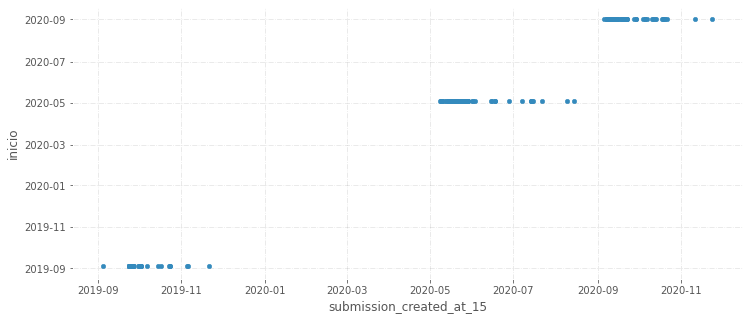

In [ ]:
# En el siguiente gráfico se ve la distribución de la fecha de inicio del ejercicio 15 entre los estudiantes

envios_ej_15_20.plot.scatter(y="inicio", x="submission_created_at_15", figsize=(12,5))

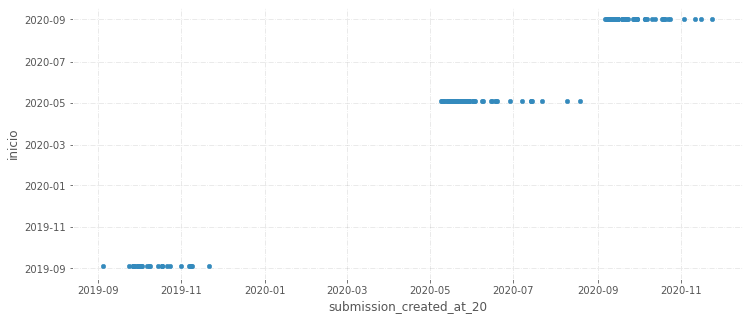

In [ ]:
# En el siguiente gráfico se ve la distribución de la fecha de inicio del ejercicio 20 entre los estudiantes

envios_ej_15_20.plot.scatter(y="inicio", x="submission_created_at_20", figsize=(12,5))

**Observación:**

En ambos gráficos vemos las 3 cohortes de la base, y además, se destacan dos estudiantes con fecha de primeros envíos "outliers" (ver detalle en la tabla siguiente). 
Probablemente pertenezcan a la cohorte II, pero decidimos eliminarlos del análisis para que no afecten las medidas descriptivas que necesitamos analizar.



In [ ]:
envios_ej_15_20[envios_ej_15_20.mes_anio == "II"].sort_values("submission_created_at_15", ascending = False).head(2)

In [ ]:
envios_ej_15_20 = envios_ej_15_20[~envios_ej_15_20.student_uid.isin([252, 253])]

In [ ]:
# Descriptivas de las variables (para todos los estudiantes): 

# * duración total del curso (inicio = primer envío; fin = último envío -dentro del cuatrimestre calendario correspondiente-)

# * tiempo transcurrido entre el inicio del curso y la resolución del ejercicio 15

# * tiempo transcurrido entre el inicio del curso y la resolución del ejercicio 20

envios_ej_15_20.describe()

**Síntesis de las descriptivas para todos los estudiantes analizados en conjunto**

* En promedio, habría que esperar **21 días** desde el comienzo de los envíos, para tener información de las resoluciones del ejercicio 15. Y **24 días** para tener las del ejercicio 20. Es decir, habría que considerar un promedio de **3 días de diferencia a esperar** entre dichos ejercicios.

* Como se puede apreciar una **alta variabilidad** en las distribuciones de estos tiempos (16 y 17 días de desviación alrededor de la medias referenciadas), observamos también las medianas y el cuartil 3 de cada distribución:  
  
  - **el valor central** de la distribución de "tiempo para llegar al ejercicio 15" es de **19 días**; y "para llegar al ejercicio 20", de **20 días**.

  - **el tercer cuartil** es **22 días** entre el incio y el ejercicio 15, y de **28 días** entre el inicio y el ejercicio 20.

  - Es decir, **entre las resoluciones del ejercicio 15 y 20 hay un día de diferencia, pero se ve una mayor dispersión de datos** respecto al tercer cuartil cuando se mira la **resolución del ejercicio 20** (3 días de desviación entre Q2 y Q3 para llegar al ejercicio 15, y 8 días de desviación entre Q2 y Q3 para llegar al ejercicio 15).

* En cualquier caso, observamos que la **mediana** en la **duración total** del curso es de **96 días**, y el máximo tiempo alcanzado para la finalización fueron 112 días.

* **En síntesis, a pesar de haber cierta variabilidad en la distribución del tiempo de resolución entre los estudiantes, podemos ver que no resulta tan significativo esperar hasta 3 días en promedio para contar con la resolución del ejercicio 20. O quizá hasta un máximo de 8 días para contar con el 75% de las resoluciones de dicho ejercicio, considerando que el recorrido total es alcanzado por el 75% de los estudiantes en 112 días.**

* Datos:
  - Para contar con la resolución del ejercicio 15 --> 22 días/112 días = 20% del tiempo total.
  - Para contar con la resolución del ejercicio 20 --> 28 días/112 días = 25% del tiempo total.
  - Diferencia de días máxima entre el 15 y el 20 --> 8/112 = 7%

* Con todo esto consideramos que, esperar entre 1 y máximo 8 días, puede ser aceptable para contar con mayor cantidad de ejercicios (y por ello mejores predicciones). Ya que esta "primera mitad de ejercicios" (1 al 20) son resueltos por los estudiantes en el primer quinto del tiempo total del cursado.




In [ ]:
# Descriptivas de las variables de tiempos, para cada cohorte en particular: 

# * duración total del curso para cada cohorte (inicio = primer envío; fin = último envío dentro del cuatrimestre calendario correspondiente)

# * tiempo transcurrido entre el inicio de cada cohorte y la resolución del ejercicio 15 de cada grupo

# * tiempo transcurrido entre el inicio de cada cohorte y la resolución del ejercicio 20 de cada grupo



envios_ej_15_20.groupby("mes_anio").describe()

student_uid                                ... tiempo_inicio_al_20                   
               count        mean        std    min  ...                 25%   50%   75%    max
mes_anio                                            ...                                       
I               46.0  110.804348  18.666214   76.0  ...                25.0  28.0  43.0   78.0
II              95.0  196.684211  30.118653  147.0  ...                11.0  20.0  23.0  106.0
III             90.0  300.377778  28.312294  254.0  ...                10.0  13.0  27.0   83.0

[3 rows x 32 columns]

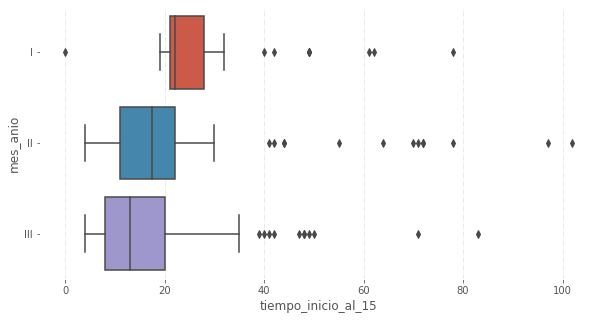

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(data = envios_ej_15_20, x = "tiempo_inicio_al_15", y="mes_anio")

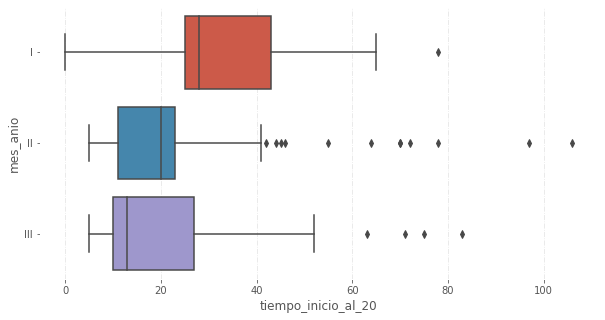

In [ ]:
plt.figure(figsize = (10,5))
sns.boxplot(data = envios_ej_15_20, x = "tiempo_inicio_al_20", y="mes_anio")

**Observaciones de las descriptivas discriminadas por cohortes de estudiantes**

* Comparativamente, vemos que el tiempo "mediano" en el que se comienzan a resolver cada uno de los ejercicios disminuye entre las sucesivas cohortes. 

* La cohorte I tiene aprox. la mitad de estudiantes que las cohortes II y III (46, 93 y 90 estudiantes respectivamente). Las últimas cohortes podrían considerarse más representativas en términos de cantidad de casos.

* Así como se observó en las descriptivas generales, en estas descriptivas por cohortes también se aprecia una mayor dispersión en los tiempos que tardan los estudiantes en llegar al ejercicio 20, vs. llegar al ejercicio 15.

* A pesar de las diferencias y variabilidades resaltadas, arribamos a las mismas conclusiones obtenidas con las descriptivas generales, en relación a nuestro problema de estudio y a las preguntas que nos habíamos planteado analizar.


**Observaciones generales del análisis del tiempo calendario**

 1) Haber descubierto que esperar entre uno a ocho días para obtener mejores predicciones resulta relativamente insignificante con respecto a la "duración total" del curso (112 días), es una muy buena información a considerar. 

 2) De todas formas, nos interesa seguir probando versiones del modelo, que permitan disminuir la cantidad de ejercicios necesarios para obtener predicciones, ya que "esperar" hasta el ejercicio 20 igual implica contar con aproximadamente "la mitad del recorrido total en términos de actividades".


### Análisis: curación de variables utilizadas

Observamos al realizar las estimaciones, que en los 2 modelos anteriores no es muy adecuado completar con 0's las celdas vacías de cada una de las variables de intentos incorrectos y de tiempo de resolución. Dichos valores perdidos, corresponden a estudiantes que no resolvieron esos ejercicios, y al completarlos con 0's, los estaríamos confundiendo con los que sí los resolvieron correctamente en el primer envío.

Por lo tanto, realizaremos un nuevo análisis donde no completaremos los `NaN`'s con `0`, si no que los dejaremos como están para decidir qué otro criterio aplicar (seleccionar/eliminar variables, o conservar las variables y decidir respecto a su imputación).

**IMPORTANTE:**

* **Necesitamos imputar los valores perdidos de las variables de intentos fallidos y de tiempo invertido, para cada ejercicio, que decidamos mantener en el dataset** (es decir, aquellas que tienen aproximadamente menos del 20% de datos perdidos).

* Para poder decidir un criterio de imputación, necesitamos hacer un supuesto respecto a qué representan los casos perdidos, y tomar una decisión.

* Describimos a continuación la línea de pensamiento que hicimos y su conclusión:

  1) Los casos perdidos de las variables intentos fallidos y tiempo invertido, son aquellos estudiantes que no enviaron resoluciones para determinados ejercicios.
  
  2) Si no enviaron soluciones, es más probable que sea porque no los sabían hacer (ejercicios difíciles para ellos), a que sea porque sí los sabían hacer.

  3) Luego, los estudiantes que saltearon ejercicios por ser “difíciles”, serían más parecidos a un perfil desertor, que a un perfil no desertor. 

  4) Por lo visto en entregas anteriores, el perfil desertor se condice con valores altos de intentos fallidos y tiempo invertido.

  5) Por lo tanto, sería lógico imputar los `NaN`'s con valores similares al del perfil desertor.
  
  6) En este sentido, consideramos que para tratar de mantener la forma de la distribución de cada variable, y no sesgar con la imputación el modelo predictivo, deberíamos asignar los`NaN`'s con el valor máximo de cada variable.

In [ ]:
data_por_estudiante = data_por_student(list(range(1, 21)), np.nan, np.nan)

# Analizamos porcentaje de datos perdidos por cada variable
(data_por_estudiante.isna().sum() / 277).sort_values(ascending = False)

intentos_incorrectos_18     0.350181
tiempo_total_18             0.350181
tiempo_total_8              0.277978
intentos_incorrectos_8      0.277978
tiempo_total_1              0.256318
intentos_incorrectos_1      0.256318
tiempo_total_20             0.223827
intentos_incorrectos_20     0.223827
intentos_incorrectos_19     0.202166
tiempo_total_16             0.202166
intentos_incorrectos_16     0.202166
tiempo_total_19             0.202166
tiempo_total_15             0.191336
intentos_incorrectos_15     0.191336
intentos_incorrectos_13     0.180505
tiempo_total_13             0.180505
tiempo_total_14             0.173285
intentos_incorrectos_14     0.173285
intentos_incorrectos_12     0.151625
tiempo_total_12             0.151625
tiempo_total_11             0.140794
intentos_incorrectos_11     0.140794
tiempo_total_10             0.111913
intentos_incorrectos_10     0.111913
tiempo_total_6              0.083032
intentos_incorrectos_6      0.083032
tiempo_total_9              0.068592
i

Si vemos por columna la cantidad de `NaN`'s, la mayoría se da en los ejercicios 18 (35%), 8 (27%), 1 (25%) y 20 (22%). 

Estos datos se corresponden con el porcentaje de estudiantes que no realizaron envíos en cada uno de estos ejercicios.

Dado que son porcentajes altos y no queremos sesgar los resultados del modelo, consideramos la posibilidad de eliminar estas variables. Pero como tampoco queremos perder la información referida a los estudiantes que no hicieron envíos en estos ejercicios, entonces pensamos en generar una variable dicotómica, que indique si hizo o no cada ejercicio.

Mostramos las métricas de dos modelos más, considerando estas opciones combinadas, para tomar una decisión final.

## Modelo 3: Regresión Logística "Mejorada" (post análisis) 

* Incluye ejercicios: **1 al 20 (quitando ejercicios 1, 8, 18, 20)**
* Imputación de NaN's en las variables tiempo invertido, e intentos fallidos (para cada ejercicio incluido) con: **máximo valor de cada variable**
* Con variable categórica (**hizo/no hizo cada ejercicio incluido**)

In [ ]:
# Generación del DF 
df_1_20_seleccionado = data_por_student(list(set(list(range(1,21)))), imputar_con_constante = False, imputacion_nan = 0)
df_1_20_seleccionado = df_1_20_seleccionado.drop(["intentos_incorrectos_1", "intentos_incorrectos_8", "intentos_incorrectos_18", "intentos_incorrectos_20", "tiempo_total_1", "tiempo_total_8", "tiempo_total_18", "tiempo_total_20"], axis = 1)
df_1_20_seleccionado

,student_uid,cond_cant_ejer_resueltos,intentos_incorrectos_10,intentos_incorrectos_11,intentos_incorrectos_12,intentos_incorrectos_13,intentos_incorrectos_14,intentos_incorrectos_15,intentos_incorrectos_16,intentos_incorrectos_19,intentos_incorrectos_2,intentos_incorrectos_3,intentos_incorrectos_6,intentos_incorrectos_9,tiempo_total_10,tiempo_total_11,tiempo_total_12,tiempo_total_13,tiempo_total_14,tiempo_total_15,tiempo_total_16,tiempo_total_19,tiempo_total_2,tiempo_total_3,tiempo_total_6,tiempo_total_9,ultimo_estado_1,ultimo_estado_10,ultimo_estado_11,ultimo_estado_12,ultimo_estado_13,ultimo_estado_14,ultimo_estado_15,ultimo_estado_16,ultimo_estado_18,ultimo_estado_19,ultimo_estado_2,ultimo_estado_20,ultimo_estado_3,ultimo_estado_6,ultimo_estado_8,ultimo_estado_9
0,76,0,1.0,1.0,0.0,1.0,0.0,7.0,0.0,0.0,0.0,1.0,0.0,4.0,20.0,60.0,0.0,12.0,0.0,1085.0,0.0,0.0,0.0,0.0,0.0,915.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,77,0,14.0,1.0,0.0,0.0,2.0,3.0,7.0,0.0,0.0,0.0,0.0,1.0,522.0,10.0,0.0,0.0,141.0,172.0,201.0,0.0,0.0,0.0,0.0,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,78,1,88.0,91.0,65.0,33.0,61.0,74.0,77.0,4.0,2.0,7.0,1.0,11.0,5592.0,11918.0,4549.0,1646.0,4343.0,5073.0,3749.0,227.0,42.0,694.0,116.0,941.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,79,1,10.0,6.0,4.0,0.0,1.0,9.0,1.0,0.0,0.0,1.0,1.0,2.0,700.0,140.0,133.0,0.0,8.0,393.0,37.0,0.0,0.0,67.0,47.0,70.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,80,1,7.0,13.0,65.0,33.0,61.0,74.0,77.0,27.0,5.0,0.0,6.0,26.0,445.0,898.0,4549.0,1646.0,4343.0,5073.0,3749.0,2134.0,249.0,0.0,216.0,1014.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,352,1,15.0,26.0,65.0,33.0,61.0,74.0,77.0,27.0,0.0,3.0,8.0,8.0,751.0,912.0,4549.0,1646.0,4343.0,5073.0,3749.0,2134.0,0.0,86.0,303.0,772.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
275,353,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
276,355,1,0.0,91.0,65.0,33.0,61.0,74.0,77.0,2.0,33.0,44.0,53.0,0.0,0.0,11918.0,4549.0,1646.0,4343.0,5073.0,3749.0,17.0,1857.0,3319.0,2879.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
277,358,1,88.0,5.0,65.0,33.0,61.0,74.0,77.0,27.0,33.0,44.0,53.0,50.0,5592.0,98.0,4549.0,1646.0,4343.0,5073.0,3749.0,2134.0,1857.0,3319.0,2879.0,2759.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
X_train_1_20_seleccionado, X_test_1_20_seleccionado, y_train_1_20_seleccionado, y_test_1_20_seleccionado, y_train_pred_lr_1_20_seleccionado, y_test_pred_lr_1_20_seleccionado = regresion_logistica(df_1_20_seleccionado, 0.3, False)

In [ ]:
print("Métricas del TRAIN para 1 al 20 (quitando ejercicios 1, 8, 18, 20), CON columna 'ultimo_estado'")
print(classification_report(y_train_1_20_seleccionado, y_train_pred_lr_1_20_seleccionado))

Métricas del TRAIN para 1 al 20 (quitando ejercicios 1, 8, 18, 20), CON columna 'ultimo_estado'
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       149
           1       0.98      0.91      0.94        46

    accuracy                           0.97       195
   macro avg       0.98      0.95      0.96       195
weighted avg       0.97      0.97      0.97       195



In [ ]:
print("Métricas del TEST para 1 al 20 (quitando ejercicios 1, 8, 18, 20), CON columna 'ultimo_estado'")
print(classification_report(y_test_1_20_seleccionado, y_test_pred_lr_1_20_seleccionado))

Métricas del TEST para 1 al 20 (quitando ejercicios 1, 8, 18, 20), CON columna 'ultimo_estado'
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        62
           1       0.84      0.95      0.89        22

    accuracy                           0.94        84
   macro avg       0.91      0.95      0.93        84
weighted avg       0.95      0.94      0.94        84



#### **Conclusión modelo 3**

* Los valores de las métricas descriptas a continuación, las observamos en el conjunto de test (ya que allí vemos la performance del modelo ante nuevas observaciones)

* Comparando con el modelo baseline, logramos una amplia mejora del RECALL de la clase 1 (de 0.47 a 0.95), aunque bajan se mantienen altas precision de clase 1 (de 0.84 a 0.82) y clase 0 (de 0.98 a 0.86). Mejora el recall de clase 0 de 0.94 a 0.97 y el accuracy en general (0.84 a 0.94).

* **Con relación al modelo 1 (que hasta ahora era el mejor)**, se observan mejoras para todas las métricas (ver en particular la mejora del RECALL de la clase 1 => 0.64 a 0.95); y precision de clase 1 (0.67 a 0.84). Accuracy pasa de de 0.82 a 0.94, y las métricas de la clase 0 también mejoran significativamente en el modelo 3 (de valores cercanos a 0.88, se pasa a valores por encima del 0.94).

* Si bien entre los datos del conjunto de train y test del Modelo 3, la precisión de la clase 1 baja, (de 0.98 a 0.84) se mantiene en un valor alto y es un resultado esperable, reflejando que el modelo no overfitea.

* Notar: Probamos este mismo modelo 3, pero quitando las variables categóricas de cada ejercicio (hizo/ no hizo) y obtuvimos métricas muy similares a las que mostramos aquí arriba (es decir incluyéndolas). Si bien esto nos llamó la atención, creemos que la diferencia casi nula en la performance del modelo al realizar dicho cambio, puede deberse a que la variable categórica no estaría influyendo mucho en las predicciones de una regresión logística.

## Modelo 4: Regresión Logística (chequeo)


* Incluye ejercicios: 1 al 20
* Con variable categórica (hizo/no hizo cada ejercicio incluido)
* Imputación de NaN's en las variables tiempo invertido, e intentos fallidos, para cada ejercicio incluido) con: máximo valor de cada variable 

In [ ]:
# Regresión logística para los primeros 20 ejercicios, CON columna de último estado:
X_train_1_20, X_test_1_20, y_train_1_20, y_test_1_20, y_train_pred_lr_1_20, y_test_pred_lr_1_20 = construir_regresion_logistica(list(range(1,21)), 0.3, False, 0, False)

In [ ]:
print("Métricas del TRAIN para primeros 20 ejercicios, CON columna 'ultimo_estado'")
print(classification_report(y_train_1_20, y_train_pred_lr_1_20))

Métricas del TRAIN para primeros 20 ejercicios, CON columna 'ultimo_estado'
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       149
           1       0.95      0.91      0.93        46

    accuracy                           0.97       195
   macro avg       0.96      0.95      0.96       195
weighted avg       0.97      0.97      0.97       195



In [ ]:
print("Métricas del TEST para primeros 20 ejercicios, CON columna 'ultimo_estado'")
print(classification_report(y_test_1_20, y_test_pred_lr_1_20))

Métricas del TEST para primeros 20 ejercicios, CON columna 'ultimo_estado'
              precision    recall  f1-score   support

           0       1.00      0.95      0.98        62
           1       0.88      1.00      0.94        22

    accuracy                           0.96        84
   macro avg       0.94      0.98      0.96        84
weighted avg       0.97      0.96      0.96        84



#### **Conclusión modelo 4 (final)**

Vemos que es correcto eliminar los ejercicios que tuvieron alto porcentaje de NaN's, ya que dejándolos el modelo muestra problemas de overfitting en test. Es decir, entendemos al ver estos resultados, que si imputamos las variables con muchos Nan con el perfil "desertor", en realidad lo que estamos haciendo es clasificar "previamente" a los estudiantes que no resolvieron ejercicios, como desertores. Y como son muchos estudiantes en esas variables, la regresión aprende el comportamiento "imputado" y luego arroja una "métrica = 1" en recall de clase 1 (también en precision de clase 0 resulta =1 y el recall de clase 0 es muy próximo a 1 = 0.95).

Por ende, el **mejor modelo** obtenido es el número **3**.

FIN